In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets

from PIL import Image

In [27]:
# class 종류
os.listdir('food/training')

['Bread',
 'Dairy product',
 'Dessert',
 'Egg',
 'Fried food',
 'Meat',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

In [28]:
train_paths = glob('food/training/*/*')
validation_paths = glob('food/validation/*/*')
test_paths = glob('food/evaluation/*/*')

In [29]:
path=train_paths[0]
path

'food/training\\Bread\\0.jpg'

In [30]:
gfile=tf.io.read_file(path)
image=tf.io.decode_image(gfile)
image.shape

TensorShape([512, 512, 3])

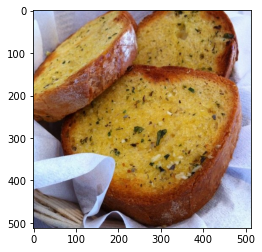

In [31]:
plt.imshow(image)
plt.show()

In [32]:
# 경로
train_dir = 'food/training'
validation_dir = 'food/validation'
test_dir = 'food/evaluation'

## Data Generator

In [76]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [77]:
target_size=(256,256)
batch_size=32

In [78]:
# image 변환
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True # 수평 뒤집기
)

# 이미지를 batch size만큼 불러와줌.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

Found 9866 images belonging to 11 classes.


In [79]:
validation_datagen = ImageDataGenerator(
    rescale=1./255.
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 3430 images belonging to 11 classes.


In [80]:
test_datagen = ImageDataGenerator(
    rescale=1./255.
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 3347 images belonging to 11 classes.


## Model

In [81]:
input_size=(256,256,3)
dropout_rate=0.7 
num_classes=len(os.listdir('food/training'))
learning_rate=0.001 # 학습률

In [82]:
inputs = layers.Input(input_size)

# Feature Extraction
net = layers.Conv2D(16,(3,3), padding='SAME')(inputs)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32,(3,3), padding='SAME')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)  # 과적합 방지 (학습시)

# Fully Connected
net = layers.Flatten()(net)
net = layers.Dense(100)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)  # 마지막 layer는 class의 개수만큼
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net)

In [85]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## Training

In [87]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

C:\Users\cody9\AppData\Local\Temp/ipykernel_16596/3554530556.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
309/309 [==============================] - 379s 1s/step - loss: 2.1976 - accuracy: 0.2229 - val_loss: 2.1059 - val_accuracy: 0.2554
Epoch 2/10
309/309 [==============================] - 377s 1s/step - loss: 2.1376 - accuracy: 0.2394 - val_loss: 2.0125 - val_accuracy: 0.2776
Epoch 3/10
309/309 [==============================] - 422s 1s/step - loss: 2.1135 - accuracy: 0.2562 - val_loss: 2.0148 - val_accuracy: 0.2787
Epoch 4/10
309/309 [==============================] - 419s 1s/step - loss: 2.0973 - accuracy: 0.2582 - val_loss: 1.9872 - val_accuracy: 0.2927
Epoch 5/10
309/309 [==============================] - 429s 1s/step - loss: 2.0631 - accuracy: 0.2701 - val_loss: 1.9688 - val_accuracy: 0.2930
Epoch 6/10
309/309 [==============================] - 411s 1s/step - loss: 2.0568 - accuracy: 0.2707 - val_loss: 1.9438 - val_accuracy: 0.2988
Epoch 7/10
309/309 [==============================] - 417s 1s/step - loss: 2.0587 - accuracy: 0.2721 - val_loss: 1.9508 - val_accuracy: 0.2988

In [88]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

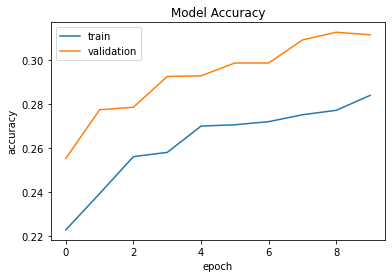

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("epoch")
plt.ylabel('accuracy')
plt.legend(['train','validation'])
plt.show()

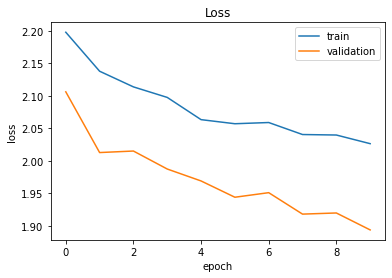

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.show()

In [93]:
scores = model.evaluate_generator(
    test_generator,
    steps=5
)

C:\Users\cody9\AppData\Local\Temp/ipykernel_16596/303220100.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(


In [103]:
scores[1]

0.03750000149011612

## Predict

In [99]:
path=test_paths[0]
path

'food/evaluation\\Bread\\0.jpg'

In [100]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)
image.shape

TensorShape([512, 512, 3])

In [101]:
image=image[tf.newaxis, ...]
image.shape

TensorShape([1, 512, 512, 3])

In [104]:
from PIL import Image

In [106]:
image=image.resize((256,256), Image.LANCZOS)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'resize'